In [1]:
import pandas as pd
import numpy as np
import itertools
import os
from tqdm import tqdm
pd.set_option('display.max_columns',None)

import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)

import matplotlib
import matplotlib.pyplot as plt
plt.rc('font',family='LGSmHaTR')
matplotlib.rcParams['axes.unicode_minus'] = False # 그래프 - 폰트 깨짐 해결

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import pickle
import string

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *

from konlpy.tag import Okt
okt = Okt()

워드클라우드

In [5]:
df = pd.read_csv("combined6.csv", encoding='cp949')

In [6]:
df.head()

,idx,담당자,업체,업체_re,날짜,건물,건물_re,건물_re_check,전처리1,내용,내용_sub,내용_concat
0,1,김인후,영선반,영선반,2017-08-29,U,U,NaN,NaN,"1층 화장실 천정 시수,공수,FCU 배관 보온 미비 부분의 결로수 발생 및 낙하로 ...",NaN,".1층 화장실 천정 시수,공수,FCU 배관 보온 미비 부분의 결로수 발생 및 낙하로..."
1,2,김인후,영선반,영선반,2017-08-29,R1,R1,NaN,NaN,공조기 #6호기 RF 모터 BRG 교체,NaN,.공조기 #6호기 RF 모터 BRG 교체
2,3,김인후,영선반,영선반,2017-08-29,R1,R1,NaN,NaN,공조기 #15호기 RF 모터 BRG 교체,NaN,.공조기 #15호기 RF 모터 BRG 교체
3,4,김인후,원동실,원동실,2017-08-29,공장,공장,NaN,NaN,매주 화요일 가스 정압실 점검 및 기록지 교체,NaN,.매주 화요일 가스 정압실 점검 및 기록지 교체
4,5,김인후,원동실,원동실,2017-08-29,"U,M,Y",각동,NaN,NaN,화재 안전 점검 실시,NaN,.화재 안전 점검 실시


In [8]:
Ext_words = []
for document in tqdm(df['내용_concat'].tolist()):
    Temp_words = []
    for word in okt.pos(document,stem=True): # 형태소 어간 추출 -> 단어/형태소
        if word[1] in ['Noun','Verb','Adjective']: # 명사,동사,형용사
            Temp_words.append(word[0])
    document = ' '.join(Temp_words)
    Ext_words.append(document)

100%|█████████████████████████████████████████████████████████████████████████████| 8431/8431 [00:11<00:00, 739.98it/s]


In [13]:
df['내용_token_1'] = Ext_words

In [9]:
Ext_words

['층 화장실 천정 수 공수 배관 보온 미비 부분 결 수 발생 및 낙하 택스 오염 발생 선반 의뢰 후 조치 완료 팀 지시 사항',
 '조기 모터 교체',
 '조기 모터 교체',
 '화요일 가스 정압 실 점검 및 기록 교체',
 '화재 안전 점검 실시',
 '층 구 협력 사 가공 조립 연마 실 에폭시 페인트 작업 호기 가동 해당 위치 배기 팬 가동 야간 연속 가동 요청',
 '층 자재 창고 출입구 페인트 작업 급 배기 실시',
 '우측 조실 허브 설치 통신 테스트 통신 선 가설 설치 진행중',
 '기계 실 출입구 건 장치 설치 팀 지시 사항',
 '서측 롤 스크린 시간 변경',
 '스팀 유량계 점검 실시 양호 스팀 유량계 차압 설정 방법 공유',
 '층 고객 지원 실 내 회의실 실내 온도 저하 디퓨져 전체',
 '층 판 수리 실 인두 배기 인하다 스마트 자재 창고 내 소음 발생 선반 의뢰 실시',
 '층 구 협력 사 가공 조립 연마 실 에폭시 페인트 작업 호기 가동 해당 위치 배기 팬 가동 야간 연속 가동 요청',
 '공사 관련 냉방 요청 외다 냉방 실시 함',
 '층 포장 라인 존 운동장 타다 냄새 신고 전화 상황 전파 방재 전기 영선 현장 확인 이상무',
 '우측 조실 통신 에러 현상 허브 설치 시 통신 정상 통신 선로 가설 시 통신 에러 발생 가설 선 허브 연결하다 사용',
 '조기 모터 교체',
 '층 구 협력 사 가공 조립 연마 실 에폭시 페인트 작업 호기 가동 해당 위치 배기 팬 가동',
 '가스 메인 보정 베터리 교체 유량 지침 보정 지침 유량 지침 우측 유량계 동일하다 변경 보정 지침 변경 사항 없다',
 '가스 기록 입다',
 '사고 대응 훈련 보일러 가스 후렌 누설 사고 실시',
 '층 실 담배 냄새 발생 휴식시간 외다 루바 근처 흡연 인하다 냄새 유입 사진 촬영 후 상황 신고 설명 실시 조치 내용 없다',
 '층 온 냉수 사용 시 검은색 물질 발생 선반 확인',
 '분진 측정기 입다 되다',
 '낙 전력 감축 실시',
 '층 제조 현장 사무실

In [11]:
## 불용어 제거
import json
with open('korean_stopword.json',encoding='utf8') as f:
    stopwords = json.load(f)

In [12]:
split_words = []
for doc in tqdm(Ext_words):
    split_words.append(doc.split())

split_filt_words = []
for doc in tqdm(split_words):
    split_temp_words = []
    for word in doc:
        if word not in stopwords:
            split_temp_words.append(word)
    split_filt_words.append(split_temp_words)

100%|███████████████████████████████████████████████████████████████████████████| 8431/8431 [00:00<00:00, 14597.90it/s]


In [14]:
df['내용_token_2'] = split_words
df['내용_token_3'] = split_filt_words

In [16]:
noun_words = []
noun_txt = [okt.nouns(doc) for doc in df['내용_concat']]
for doc in tqdm(noun_txt):
    noun_temp_words = []
    for word in doc:
        if word not in stopwords:
            noun_temp_words.append(word)
    noun_words.append(noun_temp_words)


100%|███████████████████████████████████████████████████████████████████████████| 8431/8431 [00:00<00:00, 15119.25it/s]


In [17]:
df['내용_noun'] = noun_words
df

,idx,담당자,업체,업체_re,날짜,건물,건물_re,건물_re_check,전처리1,내용,내용_sub,내용_concat,내용_token_1,내용_token_2,내용_token_3,내용_noun
0,1,김인후,영선반,영선반,2017-08-29,U,U,NaN,NaN,"1층 화장실 천정 시수,공수,FCU 배관 보온 미비 부분의 결로수 발생 및 낙하로 ...",NaN,".1층 화장실 천정 시수,공수,FCU 배관 보온 미비 부분의 결로수 발생 및 낙하로...",층 화장실 천정 수 공수 배관 보온 미비 부분 결 수 발생 및 낙하 택스 오염 발생...,"[층, 화장실, 천정, 수, 공수, 배관, 보온, 미비, 부분, 결, 수, 발생, ...","[층, 화장실, 천정, 수, 공수, 배관, 보온, 미비, 부분, 결, 수, 발생, ...","[층, 화장실, 천정, 수, 공수, 배관, 보온, 미비, 부분, 결, 수, 발생, ..."
1,2,김인후,영선반,영선반,2017-08-29,R1,R1,NaN,NaN,공조기 #6호기 RF 모터 BRG 교체,NaN,.공조기 #6호기 RF 모터 BRG 교체,조기 모터 교체,"[조기, 모터, 교체]","[조기, 모터, 교체]","[조기, 모터, 교체]"
2,3,김인후,영선반,영선반,2017-08-29,R1,R1,NaN,NaN,공조기 #15호기 RF 모터 BRG 교체,NaN,.공조기 #15호기 RF 모터 BRG 교체,조기 모터 교체,"[조기, 모터, 교체]","[조기, 모터, 교체]","[조기, 모터, 교체]"
3,4,김인후,원동실,원동실,2017-08-29,공장,공장,NaN,NaN,매주 화요일 가스 정압실 점검 및 기록지 교체,NaN,.매주 화요일 가스 정압실 점검 및 기록지 교체,화요일 가스 정압 실 점검 및 기록 교체,"[화요일, 가스, 정압, 실, 점검, 및, 기록, 교체]","[화요일, 가스, 정압, 실, 점검, 기록, 교체]","[화요일, 가스, 정압, 실, 점검, 기록, 교체]"
4,5,김인후,원동실,원동실,2017-08-29,"U,M,Y",각동,NaN,NaN,화재 안전 점검 실시,NaN,.화재 안전 점검 실시,화재 안전 점검 실시,"[화재, 안전, 점검, 실시]","[화재, 안전, 점검, 실시]","[화재, 안전, 점검, 실시]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8426,9937,이동현,원동실,원동실,2020-07-23,NaN,U,NaN,NaN,"1. U동 PCW설비점검, 이상무",NaN,".1. U동 PCW설비점검, 이상무",설비 점검 이상무,"[설비, 점검, 이상무]","[설비, 점검, 이상무]","[설비, 점검, 이상무]"
8427,9938,이동현,원동실,원동실,2020-07-23,NaN,각동,NaN,NaN,2. 삼천리 도시가스 검침 및 이메일 송부,NaN,.2. 삼천리 도시가스 검침 및 이메일 송부,삼천리 도시가스 검침 및 이메일 송부,"[삼천리, 도시가스, 검침, 및, 이메일, 송부]","[삼천리, 도시가스, 검침, 이메일, 송부]","[삼천리, 도시가스, 검침, 이메일, 송부]"
8428,9939,이동현,부스터 보일러,부스터보일러,2020-07-23,NaN,미분류,NaN,NaN,3. 경수연화장치 교체 진행중,NaN,.3. 경수연화장치 교체 진행중,경수 연화 장치 교체 진행중,"[경수, 연화, 장치, 교체, 진행중]","[경수, 연화, 장치, 교체, 진행중]","[경수, 연화, 장치, 교체, 진행중]"
8429,9940,이동현,원동실,원동실,2020-07-23,NaN,G1,NaN,NaN,"4. G1동 대강당 공조지원요청(09:00 ~ 11:00), 공조지원",NaN,".4. G1동 대강당 공조지원요청(09:00 ~ 11:00), 공조지원",대강 조지원 요청 조지원,"[대강, 조지원, 요청, 조지원]","[대강, 조지원, 요청, 조지원]","[대강, 조지원, 요청, 조지원]"


In [19]:
## Dataframe 정보를 flat하게 적용
def word_flatten(doc):
    temp_flat = []
    for words in doc:
        if type(words) == list:
            for word in words:    temp_flat.append(word)
        else:                     temp_flat.append(words)
    return temp_flat

In [21]:
nva_words = [] # Noun, Verb, Adjective 체크
for words in tqdm(df['내용_token_3']):
    nva_words.append(words)

n_words = [] # Noun 체크
for words in tqdm(df['내용_noun']):
    n_words.append(words)

va_words = [] # Verb, Adjective 체크
for i in tqdm(range(len(nva_words))):
#     print(i)
    temp = list(set(nva_words[i])-set(n_words[i]))
    if len(temp) == 0:    va_words.append("")
    else:                 va_words.append(temp)

df['내용_verb_adj'] = va_words
print(len(nva_words),len(n_words))

100%|██████████████████████████████████████████████████████████████████████████| 8431/8431 [00:00<00:00, 445631.26it/s]

8431 8431


In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib import font_manager
from collections import Counter

def word_cloud_plt(data):
    word_clouds = WordCloud(font_path = r'c:\Windows\Fonts\LGSmHaTR.ttf',
                            background_color = 'White',
                            width = 800, height = 800, 
                            colormap = 'Greens').generate_from_frequencies(Counter(data))
    fig = plt.figure(figsize = (10,10))
    plt.imshow(word_clouds.to_array())
    plt.show()

In [24]:
user_sel_data = df['내용_noun'] # 수리(처리)_token_1~3
Counter(word_flatten(user_sel_data.tolist())).most_common()
user_sel_data_re = word_flatten(user_sel_data.tolist())

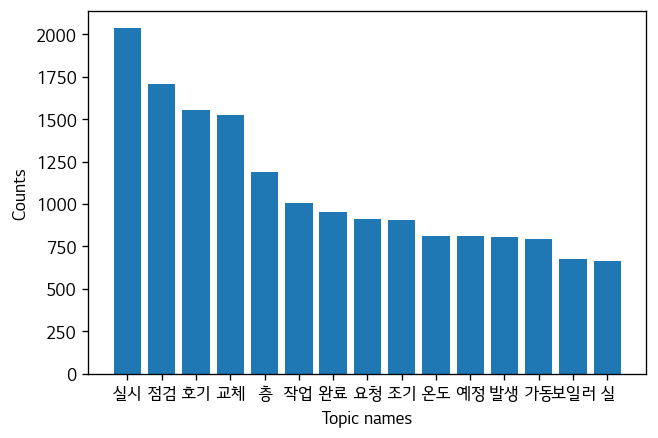

In [25]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
plt.rc('font',family='LGSmHaTR')
matplotlib.rcParams['axes.unicode_minus'] = False # 그래프 - 폰트 깨짐 해결

font_path = r'C:/Windows/Fonts/LGSmHaTR.TTF'
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font',family=font)

temp = Counter(user_sel_data_re).most_common()
temp = pd.DataFrame(temp)

plt.figure(num=2,dpi=120,facecolor='white')
plt.bar(temp[0][0:15],temp[1][0:15])
# plt.grid(True)
plt.xlabel('Topic names')
plt.ylabel('Counts')
# plt.title('The coherence score for the number of topics')
plt.show() #number of topics= 12


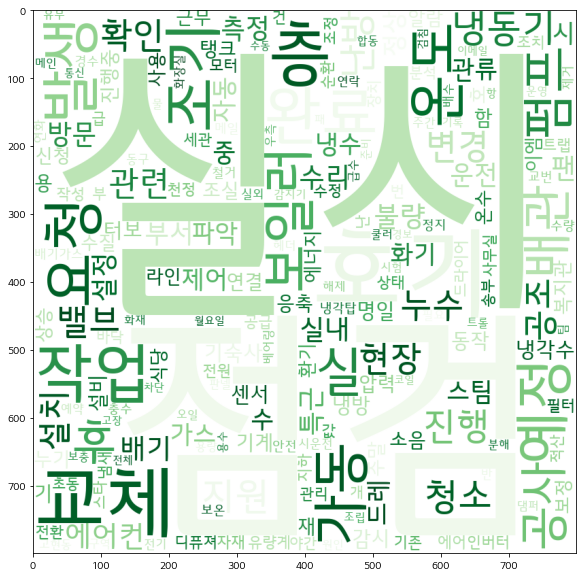

In [26]:
word_cloud_plt(user_sel_data_re)